
# US Jobs Data Project

This project downloads and collates/curates data from the US Bureau of Labor Statistics (BLS) using data from the Occupational Employment Statistics (OES) survey. 

The purpose of this project is to highlight and make accessible the excellent work of the people at BLS.

## About the BLS OES dataset

The OES dataset is remarkable, containing data for around 1,000 different occupations at national, state, and city levels. Data on numbers of jobs and pay statistics are collected.

The BLS does maintain an API which can be accessed by using a free access code: https://www.bls.gov/developers/home.htm.

Other than the API, the data from OES is available via Excel spreadsheets from a data download page: https://www.bls.gov/oes/tables.htm 

The data is also available via a web interface (https://www.bls.gov/oes/current/oes_nat.htm, for example). 

One benefit of this project is it makes all the data from different years available in one place, easily query-able via a SQLite interface, so that the data can be looked at as a time series, which is a very compelling way to understand these kinds of economic data. 

## Approach

My approach to collating this data is to download all of the excel data files and insert into a SQLite database.

## Data consistency

The main challenge to interpreting these data as a time series is changing data collection methods over time. For example, occupation codes changed in 2011 from using SOC 2000 codes to SOC 2010 codes. This can be addressed using the crosswalk provided by BLS. Other consistency issues are more difficult. For example Grand Rapids, MI seems to have been redistricted in 2015 as job numbers underwent a step change.

Historical records go back to 1988, but changing industry and area codes make curation difficult. 

The data downloaded encompassed by this project is as follows: state and national data is consistent back to 2001, while metro data goes back to 2005 when metro area codes changed. It may be possible to create a crosswalk to previous metro codes, which will be explored in the future.


# Using this project

The first thing you will need to do is to either download or construct the database.

## Download completed database

The completed SQLite database file is available for download from Google Drive:

## Build database

The database may also be constructed as follows:

In [ ]:
python download_and_save.py ## downloads and saves the Excel data files from the BLS website
python build_database_OE.py ## makes the SQLite database and inserts some necessary code tables
python get_OE_data_from_xlsx.py ## extracts the data from the Excel file and puts in to the SQLite database


# Querying the database

The database is structured around the series code for the OES survey: https://www.bls.gov/help/hlpforma.htm

The series code has the following components:

+ Area code
    + What area (national, state or metro) is the job in.
+ Industry code
    + What industry the job exists in.
+ Occupation code
    + The occupation the job exists in.
    + Occupation is distinct from industry, for example on might be an accountant (occupation) in the construction industry (industry).
+ Data type code
    + What quantity are we measuring (number of jobs, median pay, etc).

The full series code specifies each of these things and resides in the `series_code` table. 

Let's say we wanted to get the number of mechanical engineering jobs in Houston for every year available:

In [2]:
import sqlite3

conn = sqlite3.connect('OE.db') ##
query = """SELECT v.year,v.value
FROM value v --table containing values
JOIN series_code sc --table containing series_codes
ON sc.code = v.series_code
WHERE sc.area_code = 'M0026420' --area_code for Houston
AND sc.occupation_code = '172141' --occupation_code for mechanical engineers
AND sc.industry_code = '000000' --all industries
AND sc.data_type = '01' --number of jobs
ORDER BY 1 ASC;
"""
cur = conn.execute(query) 
results = cur.fetchall()

In [3]:
results

[(2005, 7300.0),
 (2006, 7560.0),
 (2007, 7380.0),
 (2008, 7510.0),
 (2009, 7760.0),
 (2010, 7510.0),
 (2011, 6730.0),
 (2012, 7570.0),
 (2013, 7720.0),
 (2014, 9260.0),
 (2015, 8760.0),
 (2016, 8470.0),
 (2017, 7530.0),
 (2018, 8130.0)]

Or let's say we wanted the total number of software dev jobs:

In [6]:
conn = sqlite3.connect('OE.db') ##
query = """SELECT v.year,SUM(v.value)
FROM value v --table containing values
JOIN series_code sc --table containing series_codes
ON sc.code = v.series_code
WHERE sc.area_code = 'N0000000' --area_code for whole country
AND sc.occupation_code IN ('151131','151132','151133','151134') --occupation_codes for software jobs
AND sc.industry_code = '000000' --all industries
AND sc.data_type = '01' --number of jobs
GROUP BY 1
ORDER BY 1 ASC;
"""
cur = conn.execute(query) 
results = cur.fetchall()

In [7]:
results

[(2001, 1124760.0),
 (2002, 1069120.0),
 (2003, 1109540.0),
 (2004, 1156000.0),
 (2005, 1165790.0),
 (2006, 1197600.0),
 (2007, 1239660.0),
 (2008, 1270220.0),
 (2009, 1248580.0),
 (2010, 1211820.0),
 (2011, 1247030.0),
 (2012, 1397770.0),
 (2013, 1442500.0),
 (2014, 1492040.0),
 (2015, 1554970.0),
 (2016, 1604560.0),
 (2017, 1617400.0),
 (2018, 1666260.0)]

And we can make a plot as follows:

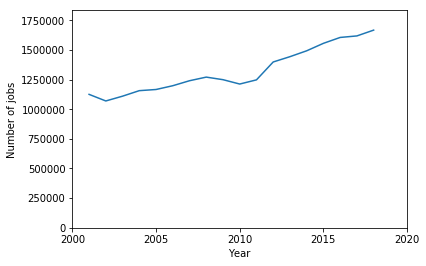

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt

x_data,y_data = list(zip(*results))
plt.plot( x_data, y_data )
plt.ylim(0,max(y_data)*1.1)
plt.xticks([2000,2005,2010,2015,2020])
plt.ylabel('Number of jobs')
plt.xlabel('Year')
plt.show()